# Tutorial 2. Introductory Matplotlib Plot Composition
The `tfv` tools package contains many methods to simplify plotting TUFLOW FV unstructured results. This guide will provide a few simple examples for developing matplotlib figures. See also the gallery notebooks for further examples.

The guide will focus on using the `tfv` xarray interface (`TfvDomain` for spatial results).

This notebook is used in combination with the [TUFLOW FV Python Toolbox](https://tfv.readthedocs.io/en/latest/index.html) (tfv) package. 
To follow along on your own computer, please download the demonstration notebooks from the [TUFLOW Downloads Page](https://www.tuflow.com/downloads/#utilities). Look for the TUFLOW FV Python Toolbox download.
Installation instructions are provided on our [TUFLOW FV Python Toolbox Wiki Page](https://fvwiki.tuflow.com/TUFLOW_FV_Python_Toolbox).


In [1]:
import xarray as xr
import tfv.xarray

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker  # Helps set tick positions
import seaborn as sns  # Not required, but this helps!
from pathlib import Path # We'll also make use of the `pathlib` module to assist with managing file-paths, although this is entirely optional! 

## Load Data

We will continue to use the TUFLOW FV example model result for this guide. This example shows a stratified estuary with dense saline water near the seabed and lighter freshwater near the surface. 

In [2]:
model_folder = Path(r'..\data')
model_file = 'HYD_002_extended.nc'

fv = xr.open_dataset(model_folder / model_file).tfv

In [3]:
fv

<xarray.Dataset>
Dimensions:      (Time: 145, NumLayerFaces3D: 7828, NumCells2D: 1375,
                  NumCells3D: 6453)
Coordinates:
  * Time         (Time) datetime64[ns] 2011-02-01 ... 2011-02-07T00:00:11.899...
Dimensions without coordinates: NumLayerFaces3D, NumCells2D, NumCells3D
Data variables:
    ResTime      (Time) timedelta64[ns] 7701 days 00:00:00 ... 7707 days 00:0...
    layerface_Z  (Time, NumLayerFaces3D) float32 ...
    stat         (Time, NumCells2D) int32 ...
    H            (Time, NumCells2D) float32 ...
    V_x          (Time, NumCells3D) float32 ...
    V_y          (Time, NumCells3D) float32 ...
    D            (Time, NumCells2D) float32 ...
    ZB           (Time, NumCells2D) float32 ...
    TEMP         (Time, NumCells3D) float32 ...
    SAL          (Time, NumCells3D) float32 ...
    RHOW         (Time, NumCells3D) float32 ...
Attributes:
    Origin:     Created by TUFLOWFV
    Type:       Cell-centred TUFLOWFV output
    spherical:  true
    Dry depth:  0.01

TUFLOW FV domain xarray accessor object

## A Note on Looking at Results Quickly

For quickly looking at model results, you do not need to use matplotlib calls and can instead use xarray directly. 

For example, you could go straight to something like `fv.plot('V', '2011-05-02 12:00')` if you just want to check out velocity; or even better, use the interactive viewing method `fv.plot_interactive('V')` - provided you are in an interactive Python session such as a Juypter notebook, and you have `ipympl` installed and activated with `%matplotlib widget`. 

**Note**: If you have matplotlib enabled with widget view (`%matplotlib widget`), you may need to use `plt.show()` or `plt.close('all')` often, because the default Jupyter behaviour to show a figure at cell execution is disabled. 

This guide is focussed on how you can use the `tfv` tools to create neat figures that can be embedded in papers, reports, presentations, and so on. For this reason, we will always set up a proper `matplotlib` figure to assist us. 

## Examples


### 1. Single instantaneous figure

When we call `fv.plot(...)` without specifying an axis the module will automatically set the axis size and aspect based on the data. This is disabled when we pass through an axis, because we often want to pre-set axis limits (e.g., a zoom and aspect). We can fix the aspect using `ax.set_aspect('equal')`.

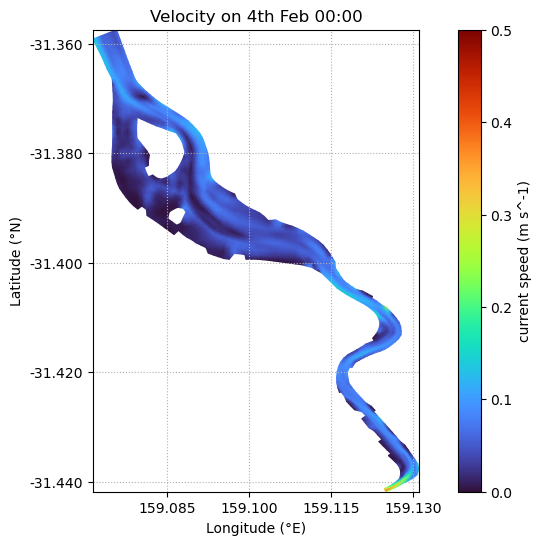

In [4]:
# It can be nice to specify the parameters above the figure
var = 'V'
time = '2011-02-04 00:00'
datum='depth'
limits=(0,2)
cspec = dict(cmap='turbo', clim=(0, 0.5), shading='interp')


fig, ax = plt.subplots(figsize=(10,6))

fv.plot(var, time, ax=ax, datum=datum, limits=limits, **cspec)

ax.set_aspect('equal')

# Some niceties
ax.set_title('Velocity on 4th Feb 00:00')
ax.set_ylabel('Latitude (°N)')
ax.set_xlabel('Longitude (°E)')
ax.grid(True, ls=':')

plt.show()

### 2. Instantaneous figure with subplots
The example estuary we are investigating exhibits vertical stratificaion, particularly for salinity. This example shows how to set up neat subplots to further investigate this behaviour.

We'll create a figure that shows velocity, temperature and salinity at three vertical levels. We'll have "surface" results on the top, "near seabed" in the middle, and "depth-averaged" results on the bottom row. 

Some setup notes:
- We'll turn off all ticks on the interior axes (we don't need to see double latitude/longitude labels)
- We've used matplotlib's ticker module to force a maximum of 3 ticks on the x-axis. You can control a lot with this module but it's all outside the scope of this guide. 
- We'll turn off axis titles on all except the top row
- We'll add a "super" title above everything describing our figure
- Seaborn (`sns.set`) is used to help us scale the font size. Alternatively, you can do this with pure matplotlib and rcParams too
- Sizing figures for TUFLOW FV results with subplots is not simple because models come in all different shapes and aspects. A simple method is to use the combination of a `figsize` param, and `constrained_layout=True` in the figure creation `plt.subplots`. Then iteratively find the optimium size to make your figure work. The alternative is to work backwards, by setting a desired figure size, and then work with the axis limits and aspect until you're happy. At this point, we're getting into pure matplotlib figure creation, of which there are plenty of good online tutorials 

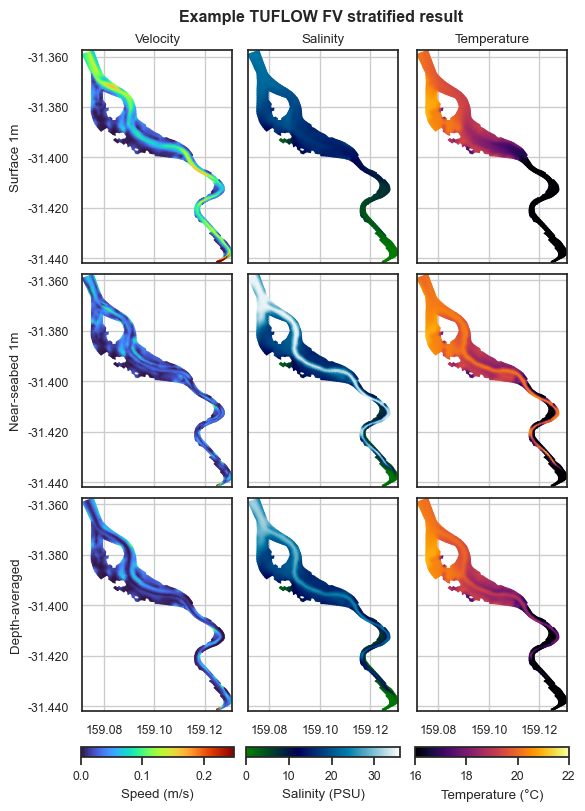

In [5]:
vel_spec = dict(cmap='turbo', clim=(0, 0.25), shading='interp', colorbar=False)
sal_spec = dict(cmap='ocean', clim=(0, 36), shading='interp', colorbar=False)
temp_spec = dict(cmap='inferno', clim=(16, 22), shading='interp', colorbar=False)

titles = {0: 'Velocity', 1: 'Salinity', 2: 'Temperature'}
ylabels = {0: 'Surface 1m', 1: 'Near-seabed 1m', 2: 'Depth-averaged'}

time = '2011-02-03 18:00'

sns.set(style='white', font_scale=0.8)

fig, axes = plt.subplots(ncols=3, nrows=3, figsize=(5.75, 8), constrained_layout=True)

# Top row - "surface" 1m.
# We assign these to a variable (c1, c2, c3) for our colorbar later.
c1 = fv.plot('V', time, ax=axes[0][0], datum='depth', **vel_spec)
c2 = fv.plot('SAL', time, ax=axes[0][1], datum='depth', **sal_spec)
c3 = fv.plot('TEMP', time, ax=axes[0][2], datum='depth', **temp_spec)

# Middle row - "bottom" 1m.
fv.plot('V', time, ax=axes[1][0], datum='height', **vel_spec)
fv.plot('SAL', time, ax=axes[1][1], datum='height', **sal_spec)
fv.plot('TEMP', time, ax=axes[1][2], datum='height', **temp_spec)

# Bottom row - Depth averaged
fv.plot('V', time, ax=axes[2][0], **vel_spec)
fv.plot('SAL', time, ax=axes[2][1], **sal_spec)
fv.plot('TEMP', time, ax=axes[2][2], **temp_spec)

# Colorbars
plt.colorbar(c1.patch, ax=axes[2][0], orientation='horizontal', label='Speed (m/s)', aspect=15)
plt.colorbar(c2.patch, ax=axes[2][1], orientation='horizontal', label='Salinity (PSU)', aspect=15)
plt.colorbar(c3.patch, ax=axes[2][2], orientation='horizontal', label='Temperature (°C)', aspect=15)

# Figure cleanup
for i in range(3): # Cols
    for j in range(3): # Rows
        ax = axes[j][i]
        
        # Common settings
        ax.set_aspect('equal')
        ax.grid(True)

        # Our xticks are too cramped - this will limit the max ticks to 3
        ax.xaxis.set_major_locator(mticker.MaxNLocator(3))
        ticks_loc = ax.get_xticks().tolist()
        ax.xaxis.set_major_locator(mticker.FixedLocator(ticks_loc))
        ax.set_xticklabels([f'{x:0.2f}' for x in ticks_loc])

        # Set titles based on our dictionary
        if j == 0:
            ax.set_title(titles[i])
        else:
            ax.set_title('')

        # Set ylabels based on our dictionary
        if i == 0:
            ax.set_ylabel(ylabels[j])

        # Turn off internal xticks
        if j != 2:
            ax.set_xticklabels([])

        # Turn off internal yticks
        if i != 0:
            ax.set_yticklabels([])

fig.suptitle('Example TUFLOW FV stratified result', fontweight='bold', x=0.55)

plt.show()

### 3. Curtain Plot
Example curtain plot for salinity. 

In [6]:
from matplotlib.gridspec import GridSpec
sns.set(style='white', font_scale=0.9)

polyline = np.loadtxt(model_folder / 'polyline.csv', skiprows=1, delimiter=',')

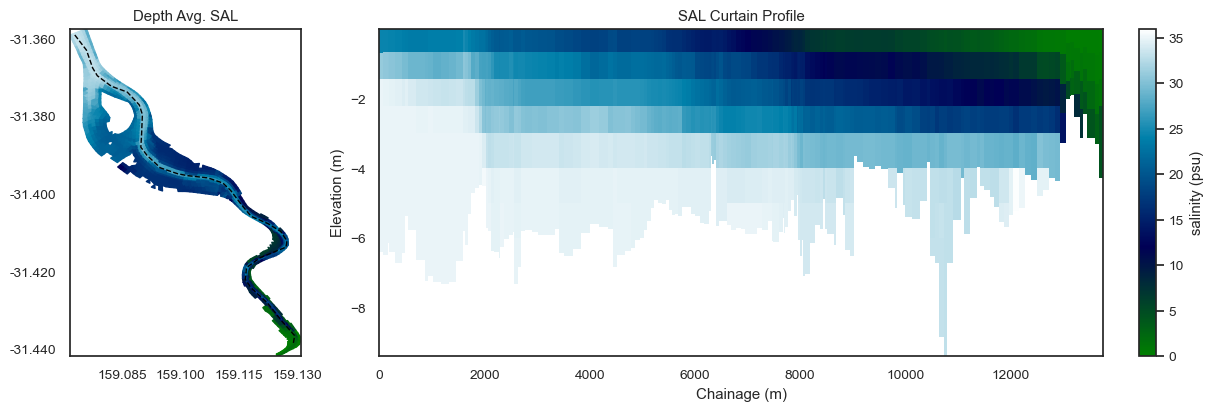

In [7]:
time = '2011-02-06 12:00'
vardict = {
    'TEMP': dict(cmap='inferno', clim=(10, 22)),
    'SAL': dict(cmap='ocean', clim=(0, 36)),
}

var = 'SAL'

# Create figure
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4), gridspec_kw={'width_ratios': [1, 3]}, constrained_layout=True)

cspec = vardict[var]
fv.plot(var, time, ax=ax1, colorbar=False, **cspec)
ax1.plot(polyline[:, 0], polyline[:, 1], lw=1, color='black', ls='--')
ax1.set_aspect('equal')
ax1.set_title(f'Depth Avg. {var}')

fv.plot_curtain(polyline, var, time, ax=ax2, ec='none', **cspec)
ax2.set_title(f'{var} Curtain Profile')

plt.show()

This concludes the introductory tfv tools matplotlib tutorial. Please see the Gallery notebooks for more examples.